In [1]:
import librosa
import numpy as np
from os import listdir
from os.path import isfile, join
from librosa import display
from sklearn.cluster import KMeans
import seaborn as sns

In [2]:
instrument_="tom"
mypathtrain='/Users/romainbourgeois/Desktop/malisProject/layered_data/'+instrument_+'/train/'
mypathtest='/Users/romainbourgeois/Desktop/malisProject/layered_data/'+instrument_+'/test/'

In [3]:
instrument = [f for f in listdir(mypathtrain) if isfile(join(mypathtrain, f))]
instrument2 = [f for f in listdir(mypathtest) if isfile(join(mypathtest, f))]

In [4]:
if '.DS_Store' in instrument:
    instrument.remove('.DS_Store')
if '.DS_Store' in instrument2:
    instrument2.remove('.DS_Store')
    #macs folders often contain DS_store files

data=[]
for i in range(len(instrument)):
    y, sr=librosa.load(mypathtrain+instrument[i], sr=22050, mono=True)
    data.append(y)
test=[]
for i in range(len(instrument2)):
    y, sr=librosa.load(mypathtest+instrument2[i], sr=22050, mono=True)
    test.append(y)
    
max_length=len(data[0])

In [5]:
len(data)

646

In [6]:
def minmaxnorm(y):
    m=max(abs(y.min()), abs(y.max()))
    z=((y+m)/m)-1
    return z

In [7]:
def energy_cdf(y):
    y=y**2
    z=np.cumsum(y, dtype=float)/np.sum(y)
    return z

In [8]:
energy=np.zeros((len(data),max_length)) # compute energy cdf for the series
p=0
for i in data:
    energy[p]=energy_cdf(i)
    p=p+1

In [9]:
energytest=np.zeros((len(test),max_length)) 
p=0
for i in test:
    energytest[p]=energy_cdf(i)
    p=p+1

In [10]:
def plot(seconds_): # plot the value of cdf at different length
    y=energy[:,round(seconds_*22050)]
    return sns.histplot(y)

<AxesSubplot:ylabel='Count'>

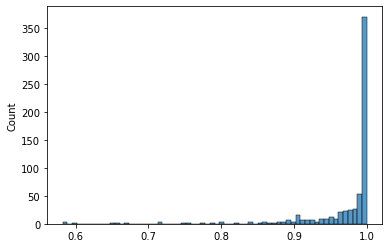

In [11]:
length=0.35
plot(length)

In [12]:
len(energy[energy[:,round(length*22050)]<0.85])/len(energy)# % of samples below 90% at length

0.03869969040247678

In [13]:
len(energy[energy[:,round(length*22050)]<0.8])/len(energy)# % of samples below 80% at length

0.02786377708978328

<AxesSubplot:ylabel='Count'>

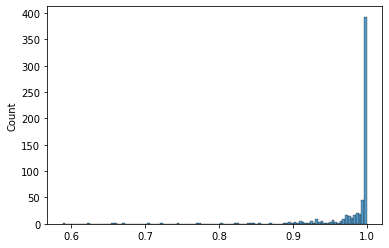

In [14]:
length=0.4
plot(length)

In [15]:
len(energy[energy[:,round(length*22050)]<0.85])/len(energy)# % of samples below 90% at length

0.030959752321981424

In [16]:
len(energy[energy[:,round(length*22050)]<0.8])/len(energy)# % of samples below 80% at length

0.018575851393188854

<AxesSubplot:ylabel='Count'>

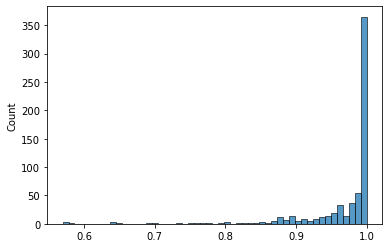

In [17]:
length=0.33
plot(length)

In [18]:
len(energy[energy[:,round(length*22050)]<0.85])/len(energy)# % of samples below 90% at length

0.04643962848297214

In [19]:
len(energy[energy[:,round(length*22050)]<0.8])/len(energy)# % of samples below 80% at length

0.030959752321981424

Take decision for the length

In [20]:
length=0.35
thresh=0.85 # cdf enrgy threshold under which samples are removed
ind_train=[] # index of samples to remove
ind_test=[] # index of samples to remove
l=len(instrument)
train=data
energytrain=energy
for i in range(len(energytrain)):
    if energytrain[i,round(length*22050)]<thresh:
        ind_train.append(i)
for i in range(len(energytest)):
    if energytest[i,round(length*22050)]<thresh:
        ind_test.append(i)

In [21]:
ind_train # index removed

[3,
 12,
 66,
 80,
 103,
 107,
 119,
 125,
 139,
 140,
 151,
 169,
 226,
 250,
 300,
 313,
 314,
 338,
 406,
 430,
 455,
 529,
 550,
 593,
 596]

In [22]:
ind_train.sort(reverse=True) # delete samples
ind_test.sort(reverse=True)
for i in ind_train:
    train=np.delete(train,i,0)
for i in ind_test:
    test=np.delete(test,i,0)
    
for i in ind_train:
    energytrain=np.delete(energytrain,i,0)
for i in ind_test:
    energytest=np.delete(energytest,i,0)

# Find maximum rate of predictions that ensure that at least all samples in the train data have an expectation to be predicted within their first cdf_threshold bound

In [23]:
sr=22050
length=length
threshold_up=0
init=0.1 # ratio of length (used to start the algo to find index cdf at cdf_target)
step=0.0005 #(ratio of length to increment the index in the algo)
cdf_target=0.8 

In [24]:
def find_thresh(datacdf, cdf_target,length,sr,threshold_up,init,step): 
    nb_points=sr*length
    upthresh_ind=round(threshold_up*nb_points)
    cdf_=[]
    for i in range(len(datacdf)):
        threshold_down=init*length 
        downthresh_ind=round(threshold_down*sr)
        cdf=datacdf[i,downthresh_ind]-datacdf[i,upthresh_ind]
        while cdf<cdf_target:
            threshold_down=threshold_down+step
            downthresh_ind=round(threshold_down*sr)
            cdf=datacdf[i,downthresh_ind]-datacdf[i,upthresh_ind]
        cdf_.append(downthresh_ind)
    return cdf_

In [25]:
trainind=find_thresh(energytrain,cdf_target=cdf_target,length=length,sr=sr,threshold_up=threshold_up,init=0.2,step=0.0005)

In [26]:
def find_R(data,cdf_,target,length,sr,threshold_up): 
    nb_points=sr*length
    upthresh_ind=round(threshold_up*nb_points)
    r_=[]
    for i in range(len(data)):
        r=1
        downthresh_ind=cdf_[i]
        diff=downthresh_ind-upthresh_ind
        base=nb_points-diff
        p=base
        p=base
        while p>target:
            p=base/r
            r=r+2
        r_.append(r)
    return r_

In [27]:
r=find_R(energytrain,cdf_=trainind,target=1.02,length=length,sr=sr,threshold_up=threshold_up)

In [28]:
import math
print(min(r), sum(r)/len(r))

1105 4872.65539452496


In [29]:
#inspect minimum Rs
r.index(min(r))
ind=[]
for i in range(len(r)):
    if r[i]==min(r):
        ind.append(i)
print("nombre de minimum",len(ind))
trainind.sort(reverse=True)
trainind # inspect the difference between second sr above

nombre de minimum 1


[6593,
 6372,
 6317,
 6229,
 6108,
 6097,
 5920,
 5887,
 5865,
 5777,
 5777,
 5777,
 5766,
 5744,
 5656,
 5656,
 5601,
 5590,
 5546,
 5490,
 5490,
 5457,
 5424,
 5413,
 5402,
 5391,
 5358,
 5303,
 5237,
 5226,
 5116,
 5094,
 5060,
 5049,
 5027,
 5005,
 4972,
 4972,
 4961,
 4928,
 4917,
 4862,
 4840,
 4818,
 4785,
 4785,
 4741,
 4730,
 4730,
 4642,
 4642,
 4619,
 4553,
 4542,
 4509,
 4498,
 4476,
 4476,
 4476,
 4454,
 4421,
 4421,
 4399,
 4366,
 4366,
 4344,
 4333,
 4322,
 4267,
 4245,
 4234,
 4223,
 4223,
 4223,
 4212,
 4212,
 4212,
 4201,
 4201,
 4190,
 4190,
 4190,
 4167,
 4156,
 4156,
 4090,
 4090,
 4002,
 4002,
 3991,
 3991,
 3969,
 3969,
 3969,
 3958,
 3947,
 3936,
 3914,
 3903,
 3881,
 3881,
 3881,
 3870,
 3859,
 3837,
 3837,
 3837,
 3826,
 3815,
 3793,
 3771,
 3749,
 3726,
 3704,
 3704,
 3693,
 3671,
 3671,
 3660,
 3649,
 3649,
 3649,
 3616,
 3616,
 3605,
 3605,
 3605,
 3605,
 3583,
 3561,
 3539,
 3528,
 3528,
 3528,
 3506,
 3506,
 3495,
 3495,
 3484,
 3473,
 3462,
 3462,
 3462,

In [30]:
for i in ind:
    print(energytrain[i,round(length*22050)]) #?

0.8559417476209081


# Padding _train

In [31]:
to_padding=[] # save the series with their target_cdf index as sample length
for i in range(len(train)):
    s=train[i,:trainind[i]]
    to_padding.append(s)

In [32]:
t_length=round(length*sr)  # sample length of prediction for that instrument
N_oversampling=3 # generate N different paddings
dataset_train=[]
for i in range(len(train)):
    padding=t_length-trainind[i]-round(threshold_up*t_length)
    rr=np.random.randint(0, high=padding, size=N_oversampling)
    for j in rr:
        dataset_train.append(np.pad(to_padding[i], (j, padding-j), 'constant'))

In [33]:
len(dataset_train)

1863

In [34]:
for i in range(len(dataset_train)):  # test if final outcome sizes equal length, something prints if problem
    if len(dataset_train[i])!=round(length*sr):
        print(i)

# Pad test set

For the test data, we will not generate padding based on the sample cdf_threshold index. We will infer the index on the distribution of indexes in the training data.

<AxesSubplot:ylabel='Count'>

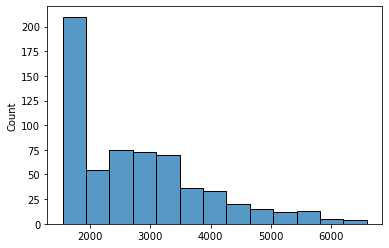

In [35]:
import seaborn as sns
from math import log
sns.histplot(trainind)

<AxesSubplot:ylabel='Count'>

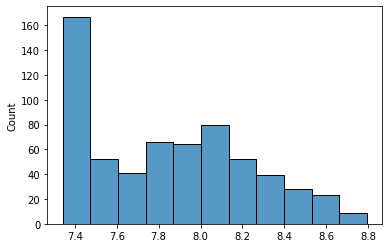

In [36]:
sns.histplot([log(x) for x in trainind])

The distribution is not normal but it is the best we got. We will hence compute its mean and std and generate indexes with a normal law.

Removing outliers:
We don't want to remove outliers on the left size, because we are sure to fit 

In [37]:
mean=np.mean(np.array([log(x) for x in trainind]))
std=np.std(np.array([log(x) for x in trainind]))

In [38]:
def remove_outliers(n,trainindex):
    if n<min([log(x) for x in trainindex]):
        n=min([log(x) for x in trainindex])
    elif n>max([log(x) for x in trainindex]):
        n=max([log(x) for x in trainindex])
    else:
        n=n
    return n

In [39]:
import math
from numpy import random
N_oversampling=3
dataset_test=[]
for i in range(len(test)):
    nn=random.normal(loc=mean, scale=std,size=1)
    for j in nn:
        j=remove_outliers(j,trainind)
        j=round(math.exp(j))
        s=test[i,:j]
        padding=t_length-j-round(threshold_up*t_length)
        rr=np.random.randint(0, high=padding, size=N_oversampling)
        for jj in rr:
            dataset_test.append(np.pad(s, (jj, padding-jj), 'constant'))

In [40]:
len(dataset_test)

456

In [41]:
for i in range(len(dataset_test)):  # test if final outcome sizes equal length
    if len(dataset_test[i])!=round(length*sr):
        print(i)

In [42]:
outpathtrain='/Users/romainbourgeois/Desktop/malisProject/data/'+instrument_+'/train/true'
outpathtest='/Users/romainbourgeois/Desktop/malisProject/data/'+instrument_+'/test/true'

In [43]:
import soundfile as sf
for i in range(len(dataset_train)):
    sf.write(outpathtrain+'/padded'+instrument_+str(i)+'.wav', dataset_train[i], 22050)

In [44]:
for i in range(len(dataset_test)):
    sf.write(outpathtest+'/padded'+instrument_+str(i)+'.wav', dataset_test[i], 22050)

In [46]:
R=min(r) # or other selection
r.sort()
R=r[1] # choose 2nd larger index R
minutes=3
nb_pred=3*60*sr
print(R,"-> decision for R")
print(nb_pred/R, "nb of predictions for a 3min song")
print(length,"-> length")

1323 -> decision for R
3000.0 nb of predictions for a 3min song
0.35 -> length
